#개요
> 새로운 개념을 위한 배경
- 머신러닝을 위한 유의미한 특성은 이미지에서 지역화된(locallized) 특성이다.
- ex) 눈과 코는 위치적으로 가까이 붙어있을 것임
- 이러한 정보는 이미지가 얼굴임을 분류할 때 중요하게 작동
- 이전의 방법들은 모든 픽셀을 항상 고려


#합성곱 CNN
> 커널
- 이미지를 보고 정보를 새로운 격자에 요약하는 방법이라고 할 수 있음
- 다양한 패턴을 골라낼 수 있는 커널을 학습시킴으로써 유의미한 패턴을 골라낼 수 있도록 함
- 유의미한 커널에 대해서는 가중치를 주고 쓸모가 없는 커널에 대해서는 가중치를 낮추어 영향력을 낮춘다

> 특성맵
- 커널을 통해 요약된 정보를 특성 맵이라고 부른다
- 특성 맵을 다시 합성곱 커널 레이어에 추가한다면 더욱 추상적인, 특성들의 조합으로 이루어진 고수준의 특성을 얻을 수 있다.
- ex) 모서리와 점을 적당히 조합하면 눈 혹은 코를 표현할 수 있으며, 눈과 코의 특성을 조합하여 얼굴을 나타낼 수 있을 것


<font color='red'><b>**요점**</b></font>
- CNN을 사용하는 요점은 커널의 모양을 인간이 지정하는 대신 네트워크가 알아서 훈련하는 것
- 저, 중, 고 수준의 이미지의 특성을 알아서 배우도록 하는 것



#MNIST CNN
- 기존의 코드에서 신경망 분류기의 정의만 살짝 수정

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

##Function

In [2]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

## Datatset Class

In [3]:
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0

        # image data, normalised from 0-255 to 0-1
        image_values = torch.cuda.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        # return label, image data tensor and target tensor
        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass

## Load Data

In [4]:
import os
os.getcwd()

'/content'

In [5]:
#데이터 로드

mnist_dataset = MnistDataset('/content/drive/MyDrive/동훈/딥러닝 스터디/GAN/DATA/mnist_train.csv')

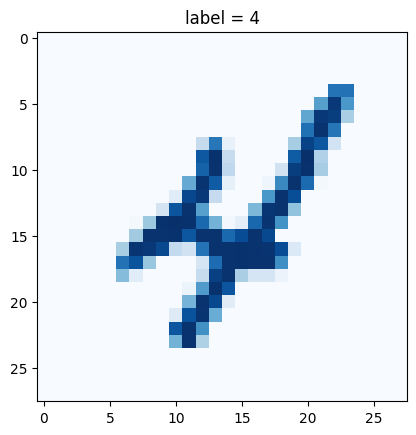

In [6]:
#이미지 확인

mnist_dataset.plot_image(9)


## 분류 네트워크




### <font color='red'><b>**질문**</b></font>
- View 없이 바로 Linear은?
- gpu 로 학습시키려면? 시도해봤는데 잘 안됨 ㅠ

In [16]:
class Classifier(nn.Module):

    def __init__(self):
        super().__init__()

        self.model= nn.Sequential(
            nn.Conv2d(1,10, 5, 2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),



            nn.Conv2d(10, 10, 3, 2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),

            # 이전 레이어까지 통화하면 10*5*5 의 특성맵이 나옴
            View(250),
            nn.Linear(250,10),
            nn.Sigmoid()
        )


        self.loss_function = nn.BCELoss()

        self.optimiser = torch.optim.Adam(self.parameters())

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        loss = self.loss_function(outputs,targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass



### 네트워크 학습

In [8]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [9]:
%%time
# create neural network

C = Classifier()
C.to(device)


# train network on MNIST data set


epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 7min 6s, sys: 7.4 s, total: 7min 14s
Wall time: 7min 55s


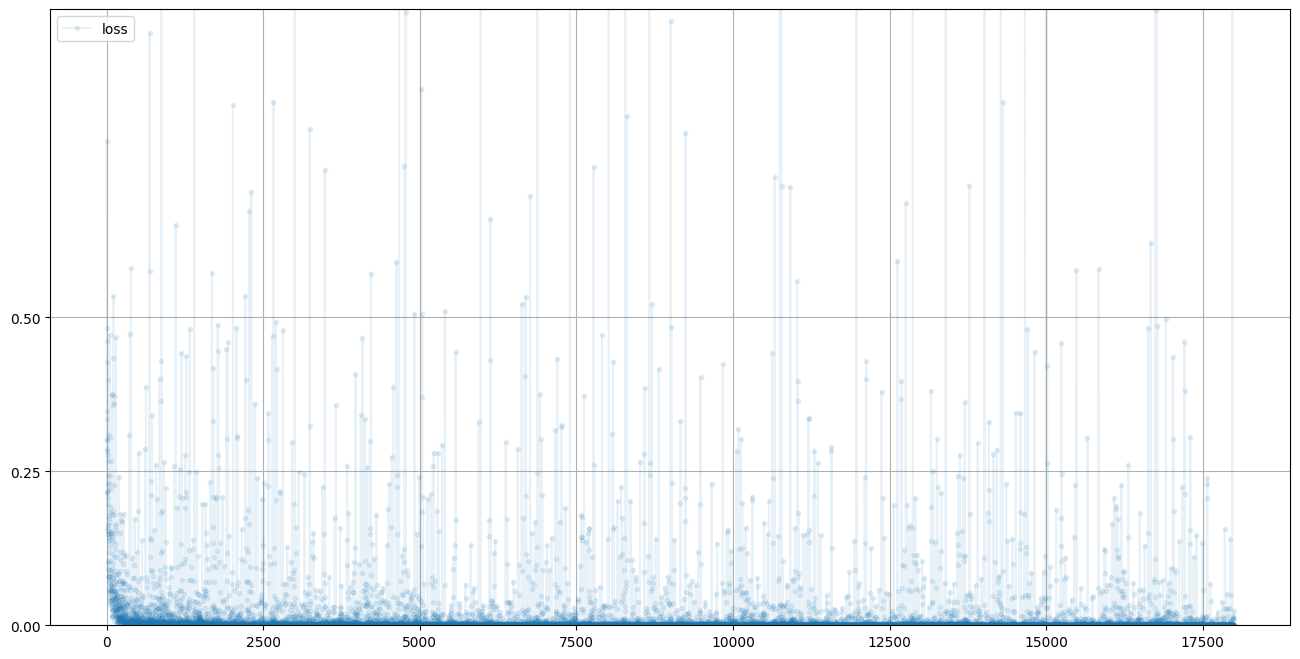

In [10]:
C.plot_progress()

이전 완전연결계층 모델보다 빠르게 0에 수렴하고 학습 시간자체도 빠름

## 분류 예시

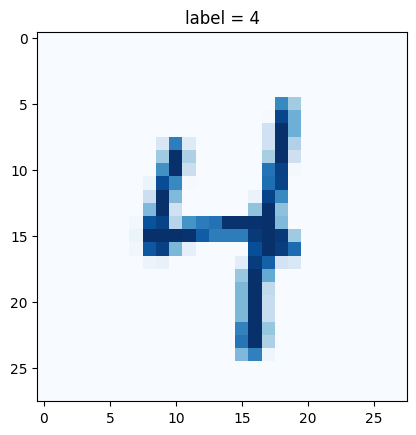

In [11]:
test_dataset = MnistDataset('/content/drive/MyDrive/동훈/딥러닝 스터디/GAN/DATA/mnist_test.csv')

record = 19
test_dataset.plot_image(record)

<Axes: >

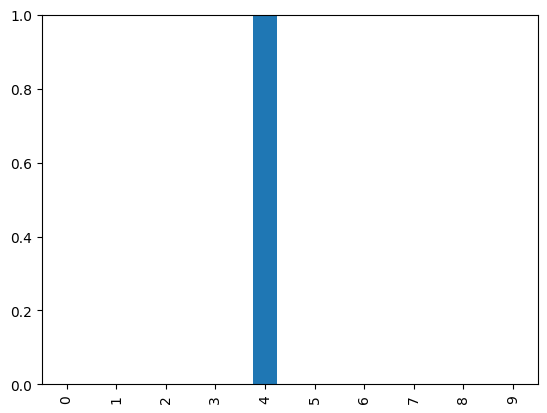

In [13]:

# visualise the answer given by the neural network

image_data = test_dataset[record][1]

# query from trained network
output = C.forward(image_data.view(1,1,28,28))

# plot output tensor
pandas.DataFrame(output.detach().cpu().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

### 분류 성능

In [15]:
score = 0
items = 0

for label, image_data_tensor, target_tensor in test_dataset:
    answer = C.forward(image_data_tensor.view(1,1,28,28)).detach().cpu().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1

    pass

print(score, items, score/items)

9810 10000 0.981
